In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report

%matplotlib inline

In [28]:
brca = pd.read_csv("Breast.csv")

brca.isnull().sum()

Patient_ID             0
Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64

In [29]:
brca.dropna(how='all', inplace=True)
brca.dropna(subset='Patient_Status', inplace = True)

In [30]:
brca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 0 to 333
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Patient_ID          321 non-null    object 
 1   Age                 321 non-null    int64  
 2   Gender              321 non-null    object 
 3   Protein1            321 non-null    float64
 4   Protein2            321 non-null    float64
 5   Protein3            321 non-null    float64
 6   Protein4            321 non-null    float64
 7   Tumour_Stage        321 non-null    object 
 8   Histology           321 non-null    object 
 9   ER status           321 non-null    object 
 10  PR status           321 non-null    object 
 11  HER2 status         321 non-null    object 
 12  Surgery_type        321 non-null    object 
 13  Date_of_Surgery     321 non-null    object 
 14  Date_of_Last_Visit  317 non-null    object 
 15  Patient_Status      321 non-null    object 
dtypes: float

In [31]:
brca['Gender'].value_counts()

FEMALE    317
MALE        4
Name: Gender, dtype: int64

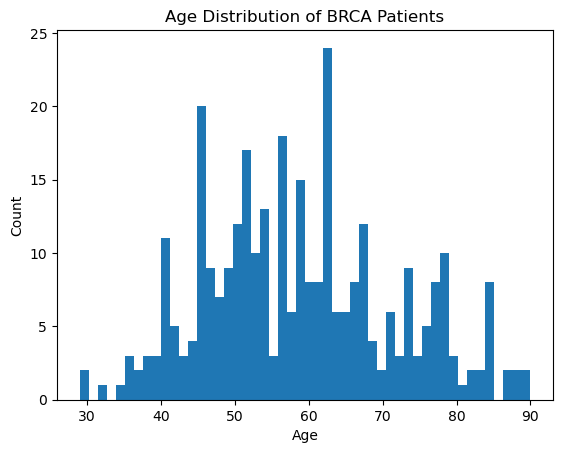

In [32]:
brca['Age'].hist(bins = 50, grid = False)
plt.xlabel(xlabel = "Age")
plt.ylabel(ylabel = "Count")
plt.title("Age Distribution of BRCA Patients")
plt.show()

In [33]:
# Display unique classifications of breast cancer in patients
brca['Histology'].unique()

array(['Infiltrating Ductal Carcinoma', 'Mucinous Carcinoma',
       'Infiltrating Lobular Carcinoma'], dtype=object)

In [34]:
def plot_pie_chart(column, title):
    # define Seaborn color palette to use
    palette_color = sns.color_palette('bright')
  
    # plotting data on chartplot_pie_chart("Tumour_Stage", "Tumour Stage Classifications in Patient Dataset")
    plt.pie(brca[column].value_counts(), labels=brca[column].unique(), colors=palette_color, autopct='%.0f%%')

    plt.title(title)
    # displaying chart
    plt.show()

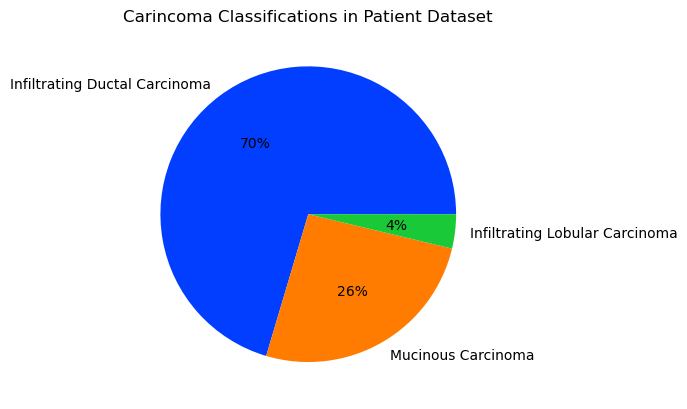

In [35]:
plot_pie_chart("Histology", "Carincoma Classifications in Patient Dataset")


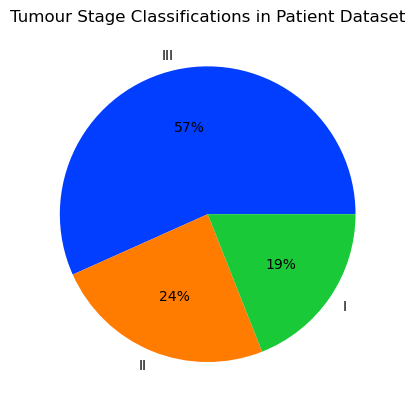

In [36]:
plot_pie_chart("Tumour_Stage", "Tumour Stage Classifications in Patient Dataset")

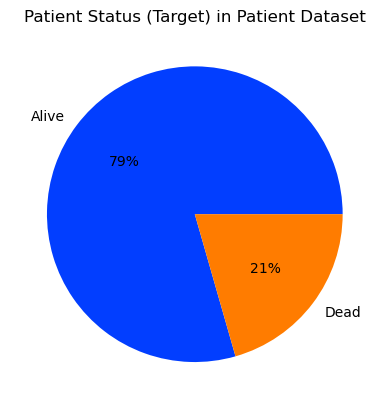

In [37]:
# Identify target feature for model prediction, two classes
plot_pie_chart("Patient_Status", "Patient Status (Target) in Patient Dataset")

In [38]:
# Make copy of original dataset and drop uninformative features
brca_processed = brca.copy().drop(columns=['Patient_ID', 'Surgery_type', 'Gender', 'ER status', 'PR status'])
# Label Encode target feature to integer for classification
le = LabelEncoder()
brca_processed['Patient_Status_le'], brca_processed['HER2_Status_le'] = le.fit_transform(brca_processed['Patient_Status']), le.fit_transform(brca_processed['HER2 status'])

In [39]:
# Ordinal encode Tumour stages from dataset categorical -> numeric
oe = OrdinalEncoder(dtype=int)
brca_processed['Tumour_Stage_oe'] = oe.fit_transform(np.array(brca_processed['Tumour_Stage']).reshape(-1,1))
brca_processed.drop(columns=['Tumour_Stage', 'Date_of_Surgery', 'Date_of_Last_Visit'], inplace=True)

In [40]:
brca_processed = pd.get_dummies(brca_processed, columns=['Histology'], dtype = int)

In [41]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(brca_processed.drop(columns=['Patient_Status', 'Patient_Status_le', 'HER2 status']), brca_processed['Patient_Status_le'], test_size = 0.15, random_state = 42, stratify=brca_processed['Patient_Status_le'])

# ## Resample dataset so that target feature is evenly distributed
oversample = SMOTE(n_jobs=100, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


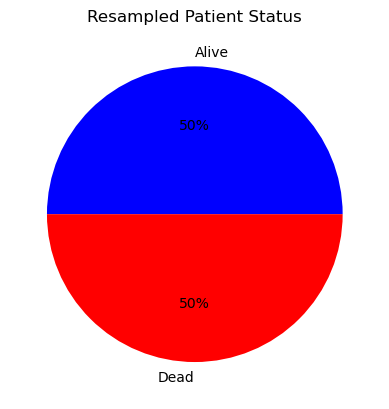

In [42]:
# plotting data on chart
plt.pie(y_train.value_counts(), labels=brca_processed['Patient_Status'].unique(), colors='bright', autopct='%.0f%%')

plt.title("Resampled Patient Status")
# displaying chart
plt.show()

In [43]:
svc = SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, n_jobs=50)
clf.fit(X_train, y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 100], 'kernel': ('linear', 'rbf')})
clf.best_estimator_

SVC(C=10, kernel='linear', probability=True)

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


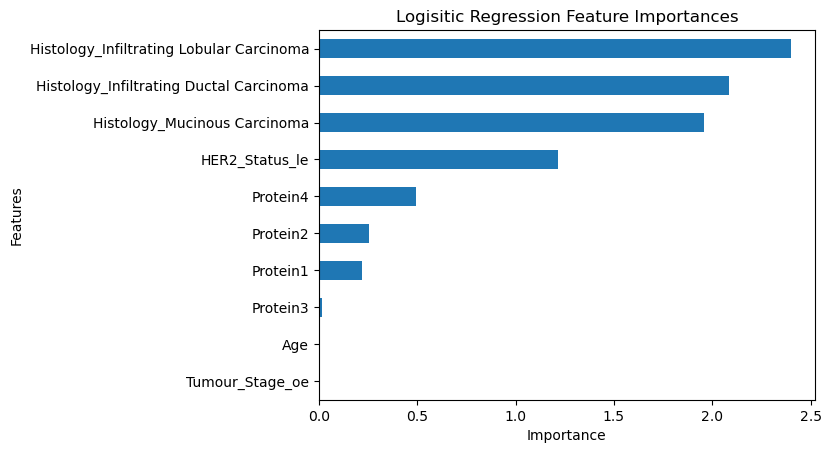

In [44]:
logit = LogisticRegression(max_iter=3500, penalty='elasticnet', solver = 'saga', l1_ratio=1)
logit.fit(X_train, y_train)
logit_importances = logit.coef_[0]
logit_feature_importances = pd.Series(index = X_train.columns, data= np.abs(logit_importances))
logit_feature_importances = logit_feature_importances.sort_values(ascending=True)
logit_feature_importances.plot(kind='barh', title = 'Logisitic Regression Feature Importances', xlabel = 'Importance', ylabel = 'Features')
plt.show()

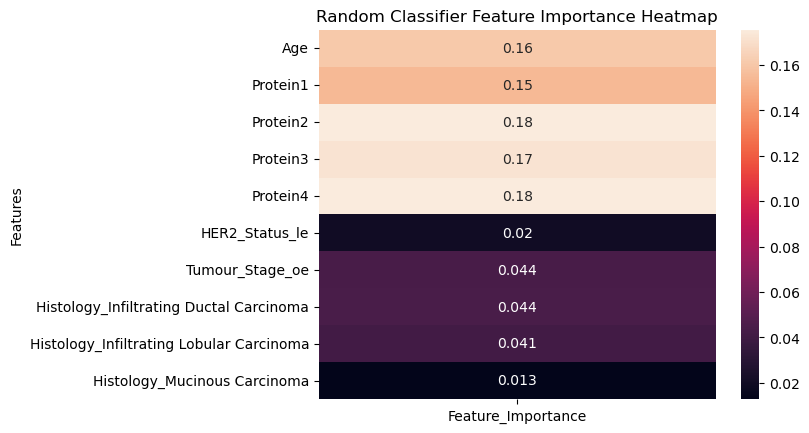

In [45]:
forest = RandomForestClassifier(n_estimators=1500)
forest.fit(X_train, y_train)
forest_feature_importance = pd.DataFrame(index = forest.feature_names_in_, data=forest.feature_importances_, columns = ['Feature_Importance'])
sns.heatmap(forest_feature_importance, annot=True).set(title = "Random Classifier Feature Importance Heatmap", ylabel='Features')
plt.show()

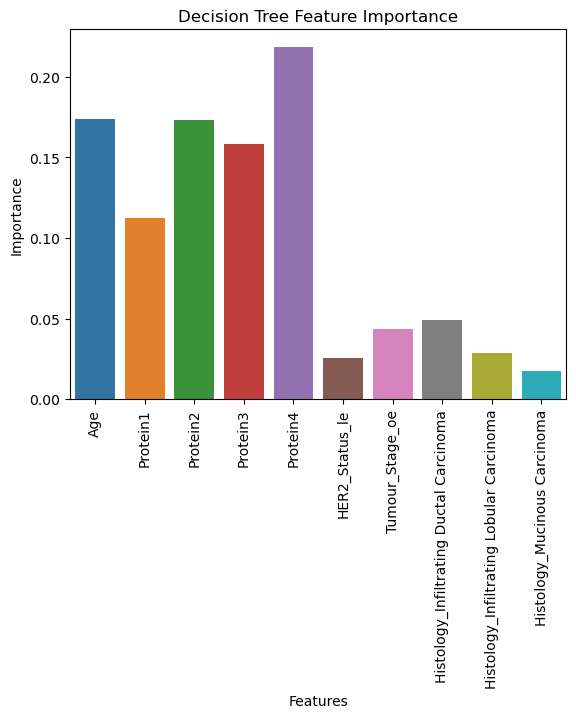

In [46]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=15)
tree_gini.fit(X_train, y_train)
tree_gini_feature_importances = pd.Series(tree_gini.feature_importances_, index=tree_gini.feature_names_in_)

sns.barplot(x = tree_gini.feature_names_in_, y = tree_gini.feature_importances_).set(title = "Decision Tree Feature Importance", xlabel='Features', ylabel='Importance')
plt.xticks(rotation = 90) 
plt.show()

In [49]:
def plot_ROC(model, title, X, Y): 
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    roc_auc = roc_auc_score(y_true=Y, y_score=model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

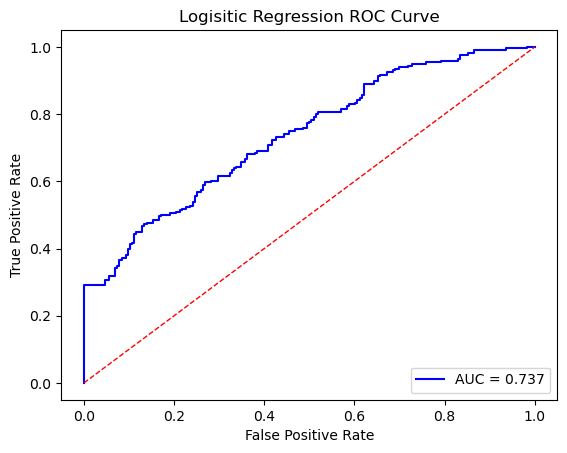

Accuracy Score: 0.6481481481481481
Confusion Matrix:
 [[164  52]
 [100 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68       216
           1       0.69      0.54      0.60       216

    accuracy                           0.65       432
   macro avg       0.66      0.65      0.64       432
weighted avg       0.66      0.65      0.64       432



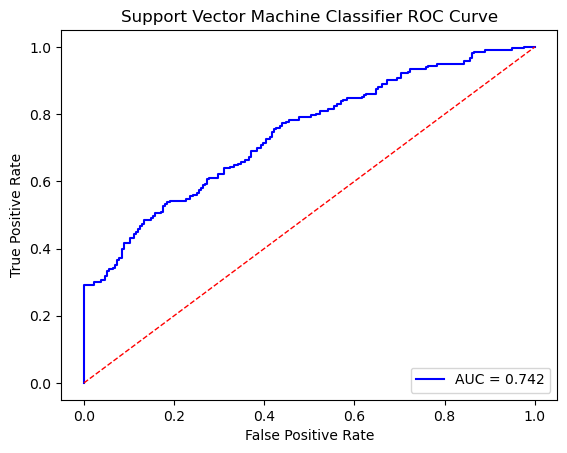

Accuracy Score: 0.6458333333333334
Confusion Matrix:
 [[216   0]
 [153  63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74       216
           1       1.00      0.29      0.45       216

    accuracy                           0.65       432
   macro avg       0.79      0.65      0.60       432
weighted avg       0.79      0.65      0.60       432



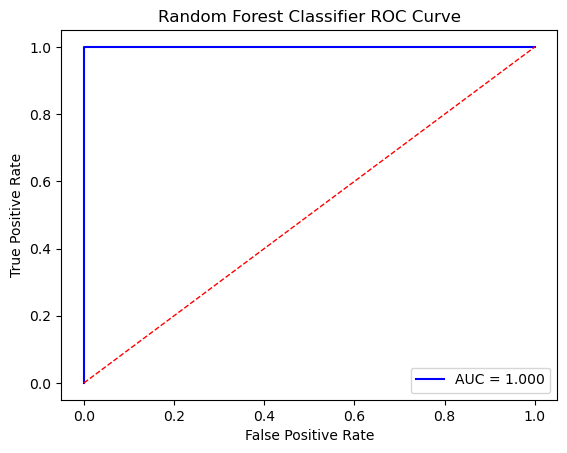

Accuracy Score: 1.0
Confusion Matrix:
 [[216   0]
 [  0 216]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



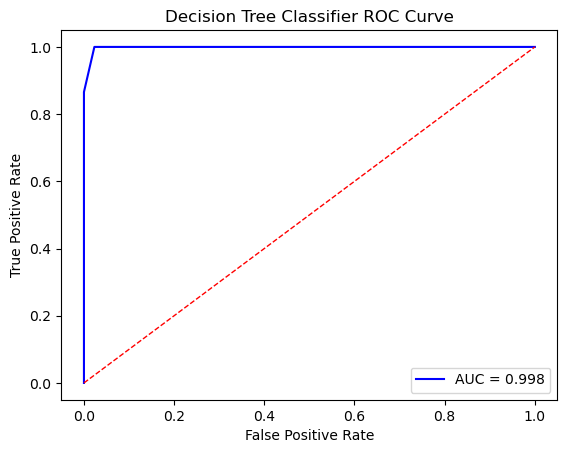

Accuracy Score: 0.9884259259259259
Confusion Matrix:
 [[211   5]
 [  0 216]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       216
           1       0.98      1.00      0.99       216

    accuracy                           0.99       432
   macro avg       0.99      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432



In [50]:
# Performance on training data
plot_ROC(logit, "Logisitic Regression ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=logit.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=logit.predict(X_train))}")

plot_ROC(clf, "Support Vector Machine Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=clf.predict(X_train))}")

plot_ROC(forest, "Random Forest Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=forest.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=forest.predict(X_train))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_train, y_train)
print(f"Accuracy Score: {accuracy_score(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_train, y_pred=tree_gini.predict(X_train))}")
print(f"Classification Report:\n {classification_report(y_true=y_train, y_pred=tree_gini.predict(X_train))}")

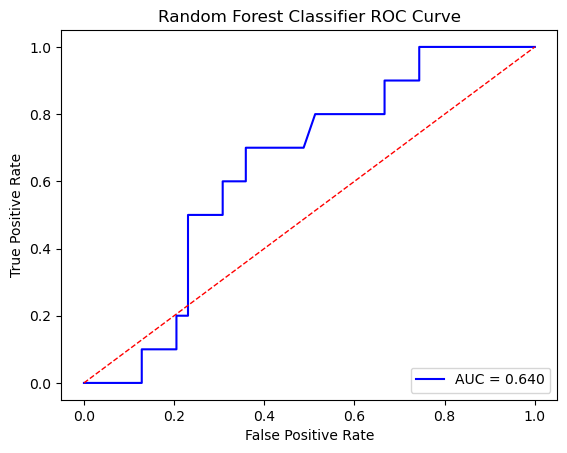

Accuracy Score: 0.7142857142857143
Confusion Matrix:
 [[35  4]
 [10  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83        39
           1       0.00      0.00      0.00        10

    accuracy                           0.71        49
   macro avg       0.39      0.45      0.42        49
weighted avg       0.62      0.71      0.66        49



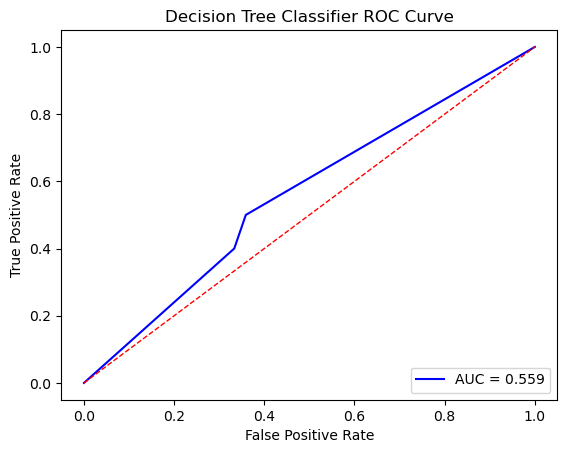

Accuracy Score: 0.6122448979591837
Confusion Matrix:
 [[25 14]
 [ 5  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.64      0.72        39
           1       0.26      0.50      0.34        10

    accuracy                           0.61        49
   macro avg       0.55      0.57      0.53        49
weighted avg       0.72      0.61      0.65        49



In [51]:
plot_ROC(forest, "Random Forest Classifier ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=forest.predict(X_test))}")

plot_ROC(tree_gini, "Decision Tree Classifier ROC Curve", X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Confusion Matrix:\n {confusion_matrix(y_true=y_test, y_pred=tree_gini.predict(X_test))}")
print(f"Classification Report:\n {classification_report(y_true=y_test, y_pred=tree_gini.predict(X_test))}")